<a href="https://colab.research.google.com/github/it21146442/Super-Ball-Pattern-/blob/main/superball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

       Draw Number                           Date    Number 1    Number 2  \
count   611.000000                            611  611.000000  611.000000   
mean   2578.011457  2024-10-01 00:16:29.852700416   15.137480   25.895254   
min    2273.000000            2023-12-01 00:00:00    1.000000    6.000000   
25%    2425.500000            2024-05-01 12:00:00    7.000000   18.000000   
50%    2578.000000            2024-10-01 00:00:00   15.000000   26.000000   
75%    2730.500000            2025-03-02 12:00:00   23.000000   34.000000   
max    2884.000000            2025-08-03 00:00:00   35.000000   49.000000   
std     176.544449                            NaN    9.037849    9.128167   

         Number 3    Number 4  Letter_Num  
count  611.000000  611.000000  611.000000  
mean    60.680851   68.623568   11.204583  
min      8.000000   19.000000    1.000000  
25%     55.000000   63.000000    5.000000  
50%     62.000000   71.000000   10.000000  
75%     69.000000   75.000000   18.000000 

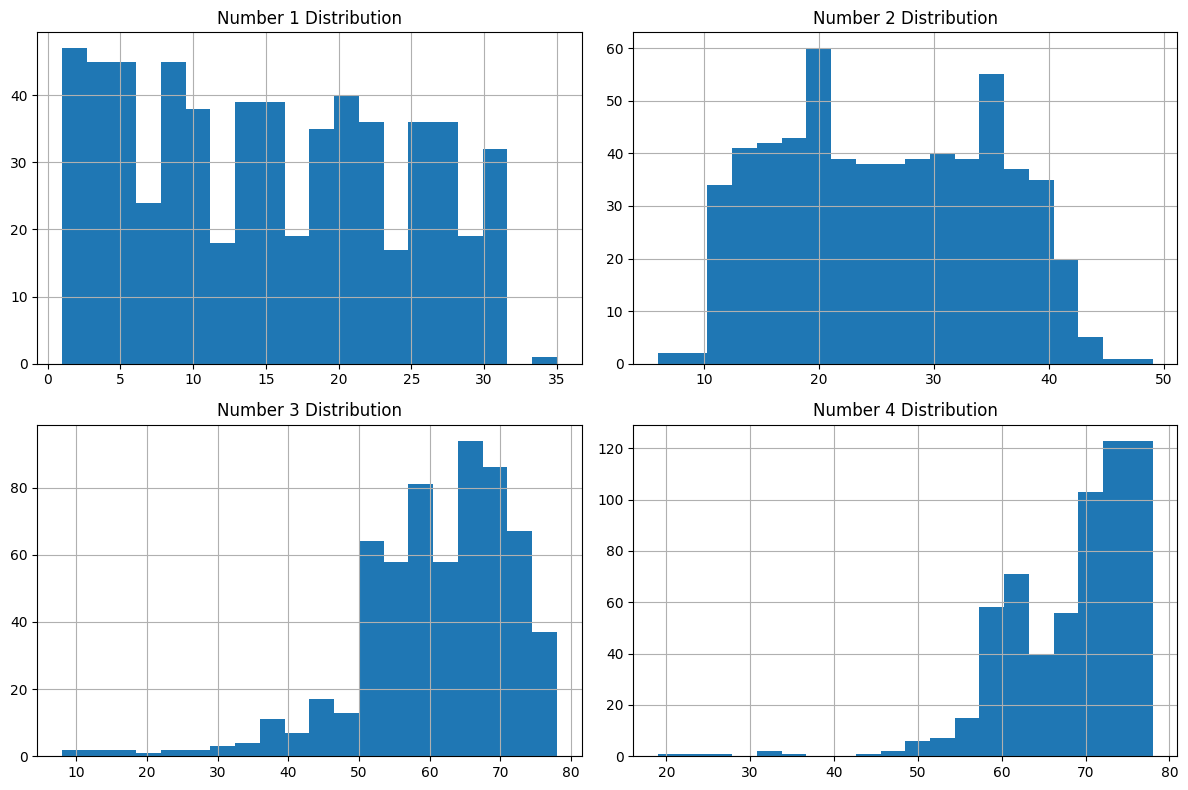

In [2]:
df = pd.read_csv('lottery_data (1).csv')  # Use your filename

# Sort by Draw Number (ascending, as higher numbers are later dates)
df = df.sort_values('Draw Number')

# Convert date to datetime for easier analysis
df['Date'] = pd.to_datetime(df['Date'])

# Map winning letter to a number (A=1, B=2, ..., V=22)
df['Letter_Num'] = df['Winning Letter'].apply(lambda x: ord(x) - ord('A') + 1)

# Basic stats
print(df.describe())
print("\nFrequency of each letter:")
print(df['Winning Letter'].value_counts())

# All numbers combined for frequency
all_numbers = pd.concat([df['Number 1'], df['Number 2'], df['Number 3'], df['Number 4']])
print("\nNumber frequencies:")
print(all_numbers.value_counts().sort_index())

# Plot histograms to check for patterns (e.g., some numbers appear more?)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
df['Number 1'].hist(bins=20)
plt.title('Number 1 Distribution')
plt.subplot(2, 2, 2)
df['Number 2'].hist(bins=20)
plt.title('Number 2 Distribution')
plt.subplot(2, 2, 3)
df['Number 3'].hist(bins=20)
plt.title('Number 3 Distribution')
plt.subplot(2, 2, 4)
df['Number 4'].hist(bins=20)
plt.title('Number 4 Distribution')
plt.tight_layout()
plt.show()


Autocorrelation for Number 1:
[ 1.          0.61118732  0.32580414  0.08837015 -0.11793505 -0.24328226
 -0.33763914 -0.35768084 -0.36160584 -0.32281458 -0.23543241]


<Figure size 640x480 with 0 Axes>

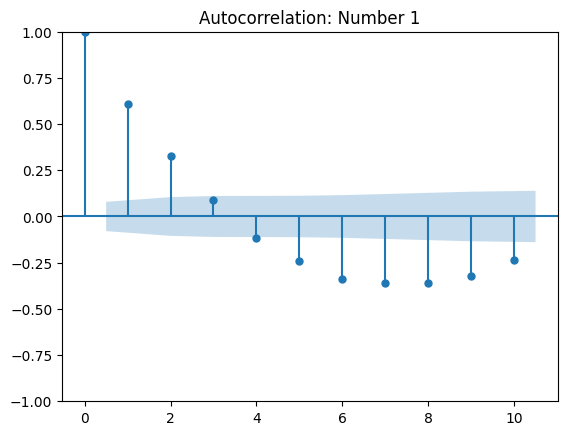


Autocorrelation for Number 2:
[ 1.          0.57171773  0.30995152  0.0737891  -0.11887213 -0.26076255
 -0.36235028 -0.39091145 -0.37941353 -0.32112635 -0.26114417]


<Figure size 640x480 with 0 Axes>

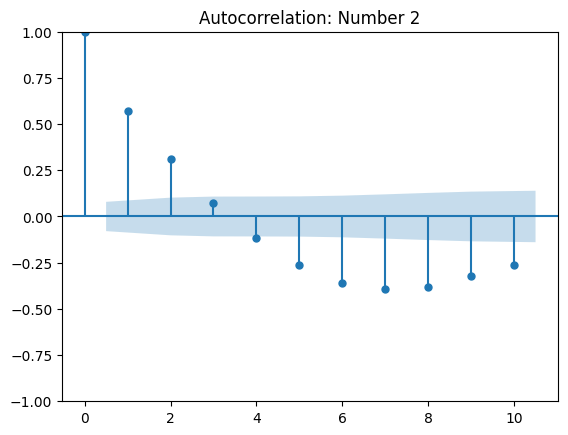


Autocorrelation for Number 3:
[1.         0.72298643 0.65359259 0.47826477 0.36373745 0.262648
 0.20387806 0.15703111 0.14626865 0.15758288 0.17644465]


<Figure size 640x480 with 0 Axes>

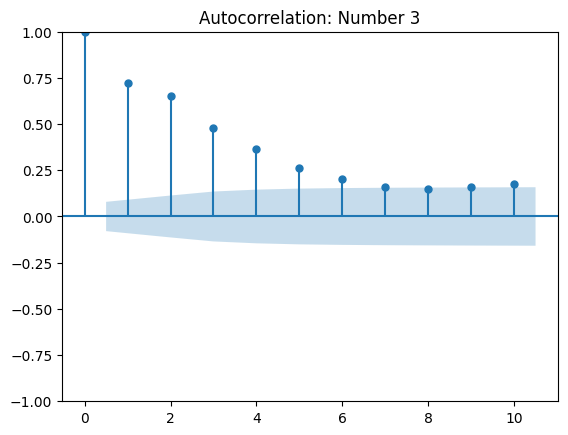


Autocorrelation for Number 4:
[ 1.          0.43953787  0.24155458  0.04192157  0.10831671  0.18084042
  0.07099292 -0.07130079 -0.11082435 -0.01776024  0.10784463]


<Figure size 640x480 with 0 Axes>

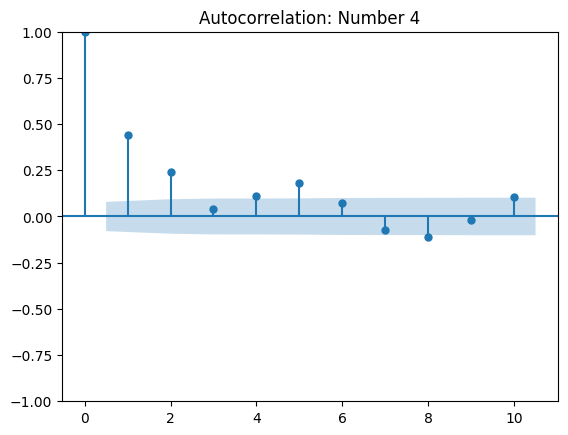

In [3]:
# Autocorrelation for each number column (lags up to 10 previous draws)
for col in ['Number 1', 'Number 2', 'Number 3', 'Number 4']:
    acf = sm.tsa.acf(df[col], nlags=10)
    print(f"\nAutocorrelation for {col}:")
    print(acf)
    plt.figure()
    sm.graphics.tsa.plot_acf(df[col], lags=10)
    plt.title(f'Autocorrelation: {col}')
    plt.show()

In [4]:
# Differences between consecutive numbers in a draw
df['Diff1_2'] = df['Number 2'] - df['Number 1']
df['Diff2_3'] = df['Number 3'] - df['Number 2']
df['Diff3_4'] = df['Number 4'] - df['Number 3']
print("\nAverage differences:")
print(df[['Diff1_2', 'Diff2_3', 'Diff3_4']].mean())


Average differences:
Diff1_2    10.757774
Diff2_3    34.785597
Diff3_4     7.942717
dtype: float64


In [5]:
# Focus on number columns
numbers = df[['Number 1', 'Number 2', 'Number 3', 'Number 4']].values

# Create sequences: use past 5 draws to predict the next
sequence_length = 5
X = []
y = []
for i in range(len(numbers) - sequence_length):
    X.append(numbers[i:i+sequence_length].flatten())  # Flatten to 1D: 5 draws * 4 numbers = 20 features
    y.append(numbers[i+sequence_length])  # Next 4 numbers

X = np.array(X)
y = np.array(y)

# Normalize (scale to 0-1, helps ML models)
X = X / 78.0  # Assuming max number is 78 from your data
y = y / 78.0

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # No shuffle for time series

In [6]:


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add seq dim for LSTM: (batch, seq_len=1, features)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Simple LSTM model
class LotteryLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=20, hidden_size=50, num_layers=1, batch_first=True)  # Input: 20 features (5*4)
        self.fc = nn.Linear(50, 4)  # Output: 4 numbers

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Last time step
        return out

model = LotteryLSTM()
criterion = nn.MSELoss()  # Mean squared error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
epochs = 100
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# Test
model.eval()
with torch.no_grad():
    test_output = model(X_test)
    test_loss = criterion(test_output, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Predict next (example: use last 5 from data)
last_5 = torch.tensor(numbers[-sequence_length:].flatten() / 78.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
predicted = model(last_5).detach().numpy() * 78  # Scale back
print("\nPredicted next numbers:", predicted.round().astype(int))

Epoch 10, Loss: 0.0138
Epoch 20, Loss: 0.0027
Epoch 30, Loss: 0.0035
Epoch 40, Loss: 0.0039
Epoch 50, Loss: 0.0041
Epoch 60, Loss: 0.0238
Epoch 70, Loss: 0.0053
Epoch 80, Loss: 0.0139
Epoch 90, Loss: 0.0026
Epoch 100, Loss: 0.0019
Test Loss: 0.0188

Predicted next numbers: [[19 26 44 46]]
